In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


## Converting Data into Pandas DataFrame

In [2]:
train_data = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
test_data = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')

## Identifying the datatypes of the columns given in traning and test dataset

In [3]:
print('The datatypes of the columns given in the training dataset are: ')
print(train_data.dtypes)

print('The datatypes of the columns given in the test dataset are: ')
print(test_data.dtypes)

The datatypes of the columns given in the training dataset are: 
id               int64
airline         object
flight          object
source          object
departure       object
stops           object
arrival         object
destination     object
class           object
duration       float64
days_left      float64
price            int64
dtype: object
The datatypes of the columns given in the test dataset are: 
id               int64
airline         object
flight          object
source          object
departure       object
stops           object
arrival         object
destination     object
class           object
duration       float64
days_left      float64
dtype: object


## Presenting descriptive statistics of numerical columns

In [4]:
train_data.describe()
test_data.describe()

,id,duration,days_left
count,10000.00000,9418.000000,9304.000000
mean,4999.50000,12.005125,26.163156
std,2886.89568,7.086652,13.453717
min,0.00000,0.920000,1.000000
25%,2499.75000,6.670000,15.000000
50%,4999.50000,11.170000,26.000000
75%,7499.25000,15.920000,38.000000
max,9999.00000,40.420000,49.000000


## Identifying and handling the missing values

In [5]:
from sklearn.impute import SimpleImputer

print('\nTotal number of missing values in the training dataset:',train_data.isnull().sum().sum())

print('\nTotal number of missing values in the test dataset:',test_data.isnull().sum().sum())

num_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = train_data.select_dtypes(include=['object', 'category', 'bool']).columns

# For numerical
num_imputer = SimpleImputer(strategy='median')
train_data[num_cols] = num_imputer.fit_transform(train_data[num_cols])

# For categorical
cat_imputer = SimpleImputer(strategy='most_frequent')
train_data[cat_cols] = cat_imputer.fit_transform(train_data[cat_cols])

num_cols1 = test_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols1 = test_data.select_dtypes(include=['object', 'category', 'bool']).columns

# For numerical
num_imputer1 = SimpleImputer(strategy='median')
test_data[num_cols1] = num_imputer1.fit_transform(test_data[num_cols1])

# For categorical
cat_imputer1 = SimpleImputer(strategy='most_frequent')
test_data[cat_cols1] = cat_imputer1.fit_transform(test_data[cat_cols1])


Total number of missing values in the training dataset: 19175

Total number of missing values in the test dataset: 3397


## Identifying and handling duplicates

In [6]:
print('Total number of duplicates are: ', train_data.duplicated().sum())
print('Total number of duplicates are: ', test_data.duplicated().sum())

train_data = train_data.drop_duplicates(keep = 'last')
test_data = test_data.drop_duplicates(keep = 'last')

Total number of duplicates are:  0
Total number of duplicates are:  0


## Identifying and handling outliers

In [7]:
for col in num_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = train_data[(train_data[col] < lower_bound) | (train_data[col] > upper_bound)]
    print(f"\nOutliers in '{col}': {len(outliers)}")


def get_identifier_columns(df):
    return [col for col in df.columns if df[col].nunique() == len(df)]

def identify_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper
def cap_outliers(df, col):
    lower, upper = identify_outliers(df, col)
    df[col] = np.where(df[col] > upper, upper,
               np.where(df[col] < lower, lower, df[col]))
    return df

def process_flight_data(df):
    # Step 1: Detect and report identifier
    id_cols = get_identifier_columns(df)
    print("Identifier Columns:", id_cols)
    print("Number of Identifiers:", len(id_cols))

    # Step 2: Handle outliers in numerical columns
    for col in ['duration', 'days_left', 'price']:
        if col in df.columns:
            if col == 'price':
                df = df[df[col] > 0]  # remove invalid price
            df = cap_outliers(df, col)

    # Step 3: Log-transform price to handle skew
    if 'price' in df.columns:
        df['price'] = np.log1p(df['price'])

    return df
    
train_data_cleaned = process_flight_data(train_data)

test_data_cleaned = process_flight_data(test_data)



Outliers in 'id': 0

Outliers in 'duration': 470

Outliers in 'days_left': 0

Outliers in 'price': 14
Identifier Columns: ['id']
Number of Identifiers: 1
Identifier Columns: ['id']
Number of Identifiers: 1


## Presenting three visualizations and providing insights

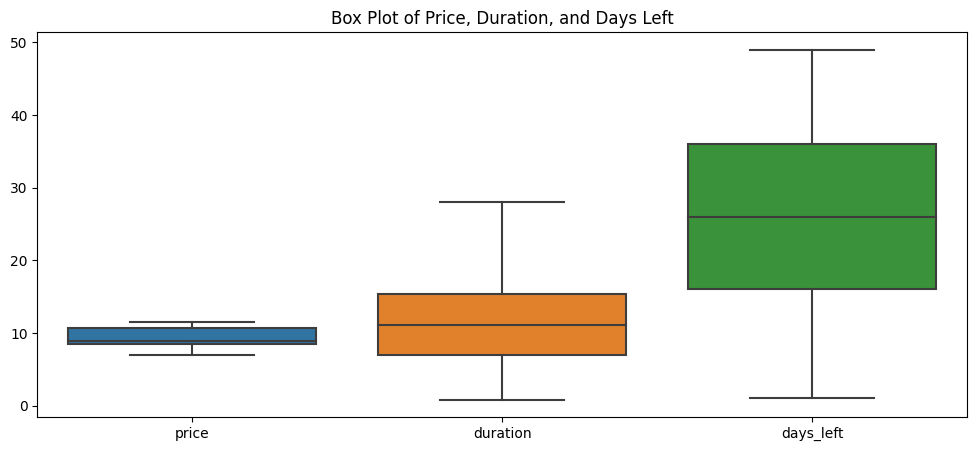

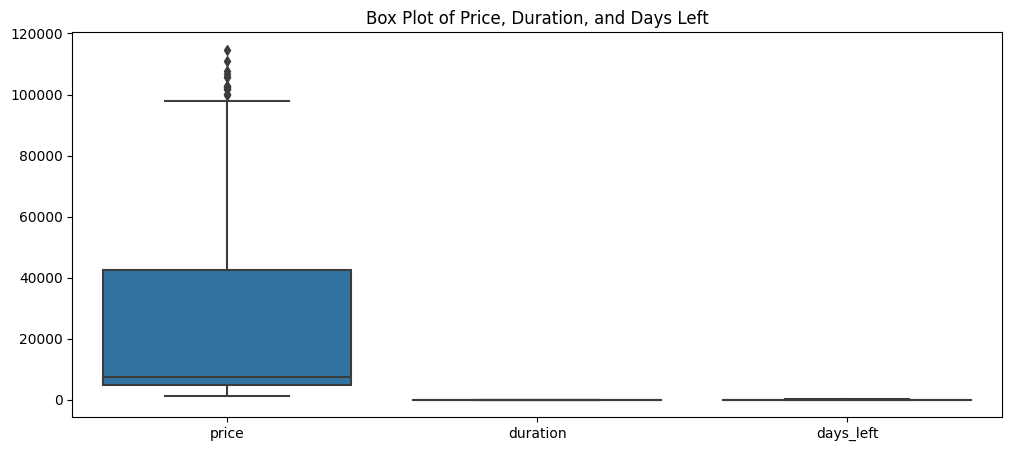

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# For the cleaned training data
plt.figure(figsize=(12, 5))
sns.boxplot(data = train_data_cleaned[['price', 'duration', 'days_left']])
plt.title('Box Plot of Price, Duration, and Days Left')
plt.show()

# For the training data with outliers

plt.figure(figsize=(12, 5))
sns.boxplot(data = train_data[['price', 'duration', 'days_left']])
plt.title('Box Plot of Price, Duration, and Days Left')
plt.show()

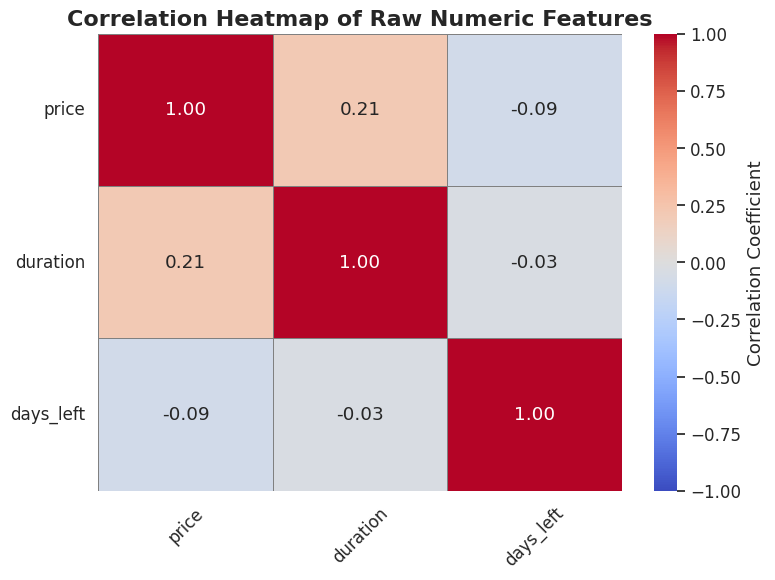

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid", font_scale=1.1)

corr = train_data[['price', 'duration', 'days_left']].corr()
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title('Correlation Heatmap of Raw Numeric Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

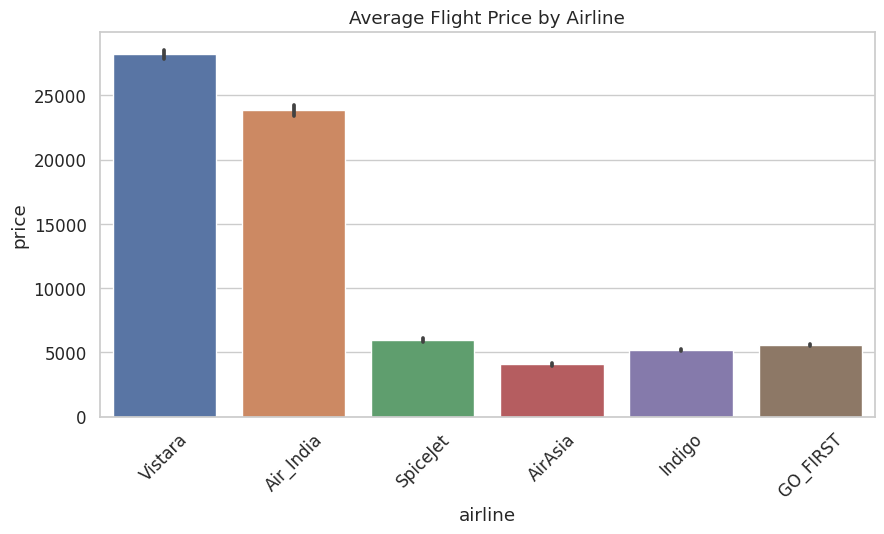

In [10]:
# For training data with outliers
plt.figure(figsize=(10, 5))
sns.barplot(x='airline', y='price', data = train_data)
plt.xticks(rotation=45)
plt.title('Average Flight Price by Airline')
plt.show()

## Scaling numerical features and Encoding categorical features

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, target='price'):
    df = df.copy()

    # Drop identifier
    if 'id' in df.columns:
        df = df.drop(columns=['id'])

    y = None
    if target is not None and target in df.columns:
        # Drop rows with missing or invalid target
        df = df.dropna(subset=[target])
        df = df[df[target] > 0]

        # Separate target
        y = df[target]
        df = df.drop(columns=[target])

    # Split columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Scale numeric
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    # Encode categorical
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    return (df, y) if y is not None else (df, None)

    
X, y = preprocess_data(train_data, target='price')

## Model Building

In [12]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sample = X.sample(1000, random_state=42)
X_sample = sample
y_sample = y.loc[sample.index]  # y aligned with X


def fast_evaluate_models(X, y, models):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        rmse = mean_squared_error(y_test, preds, squared=False)

        print(f"\n📌 {name}")
        print(f"✅ R² Score: {r2:.3f}")
        print(f"✅ RMSE    : {rmse:.2f}")

fast_evaluate_models(X_sample, y_sample, models)


📌 Linear Regression
✅ R² Score: -118536783503355868610560.000
✅ RMSE    : 8299274840521867.00

📌 Ridge Regression
✅ R² Score: 0.899
✅ RMSE    : 7651.82

📌 Decision Tree
✅ R² Score: 0.848
✅ RMSE    : 9394.39

📌 Random Forest
✅ R² Score: 0.924
✅ RMSE    : 6667.14

📌 Gradient Boosting
✅ R² Score: 0.928
✅ RMSE    : 6445.83

📌 Support Vector Regressor
✅ R² Score: -0.383
✅ RMSE    : 28346.84

📌 K-Nearest Neighbors
✅ R² Score: 0.567
✅ RMSE    : 15864.03


## Hyperparameter tuning

In [14]:
from sklearn.model_selection import RandomizedSearchCV

def fast_tune_random_forest(X_train, y_train):
    print("\n🎯 Tuning: Random Forest")
    param_dist = {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    grid = RandomizedSearchCV(RandomForestRegressor(), param_dist, n_iter=10, cv=3,
                              scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
    grid.fit(X_train, y_train)
    print("✅ Best Params:", grid.best_params_)
    return grid.best_estimator_

def fast_tune_gbr(X_train, y_train):
    print("\n🎯 Tuning: Gradient Boosting")
    param_dist = {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    }
    grid = RandomizedSearchCV(GradientBoostingRegressor(), param_dist, n_iter=10, cv=3,
                              scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
    grid.fit(X_train, y_train)
    print("✅ Best Params:", grid.best_params_)
    return grid.best_estimator_
    
def fast_tune_knn(X_train, y_train):
    print("\n🎯 Tuning: KNN Regressor")
    param_dist = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # 1=Manhattan, 2=Euclidean
    }

    grid = RandomizedSearchCV(KNeighborsRegressor(), param_dist, n_iter=10, cv=3,
                              scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=1)
    grid.fit(X_train, y_train)
    print("✅ Best Params:", grid.best_params_)
    return grid.best_estimator_

In [15]:
results = []

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Print results
    print(f"\n📌 {name}")
    print("R² Score:", round(r2, 3))
    print("RMSE:", round(rmse, 2))

    # Store for comparison
    results.append({
        'Model': name,
        'R² Score': round(r2, 3),
        'RMSE': round(rmse, 2)
    })
    
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

# Tune
best_rf = fast_tune_random_forest(X_train, y_train)
best_gbr = fast_tune_gbr(X_train, y_train)
best_knn = fast_tune_knn(X_train, y_train)

# Evaluate
evaluate_model("Random Forest (Tuned)", best_rf, X_test, y_test)
evaluate_model("Gradient Boosting (Tuned)", best_gbr, X_test, y_test)
evaluate_model("KNN Regressor (Tuned)", best_knn, X_test, y_test)


🎯 Tuning: Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Params: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

🎯 Tuning: Gradient Boosting
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}

🎯 Tuning: KNN Regressor
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best Params: {'weights': 'distance', 'p': 1, 'n_neighbors': 9}

📌 Random Forest (Tuned)
R² Score: 0.925
RMSE: 6621.44

📌 Gradient Boosting (Tuned)
R² Score: 0.918
RMSE: 6912.94

📌 KNN Regressor (Tuned)
R² Score: 0.65
RMSE: 14267.13


## Comparison of model performances


📋 Model Comparison Table:
                       Model  R² Score      RMSE
0      Random Forest (Tuned)     0.925   6621.44
1  Gradient Boosting (Tuned)     0.918   6912.94
2      KNN Regressor (Tuned)     0.650  14267.13


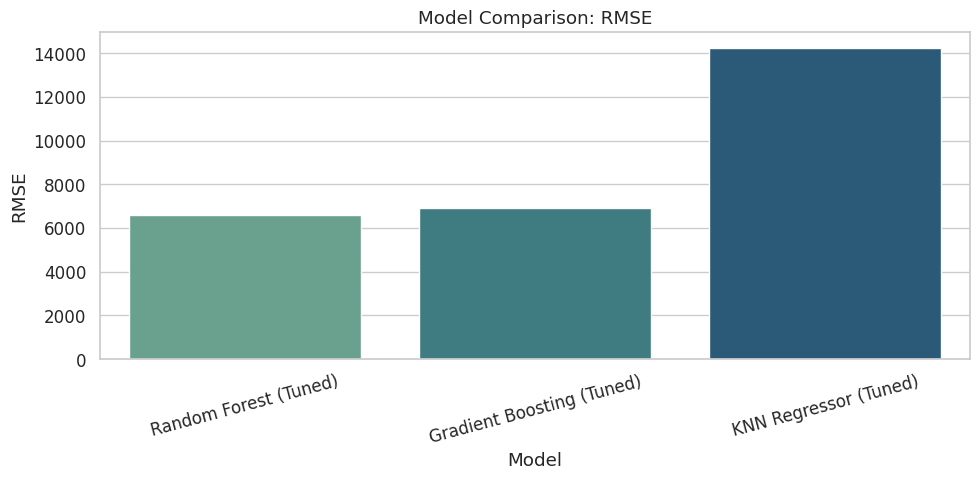

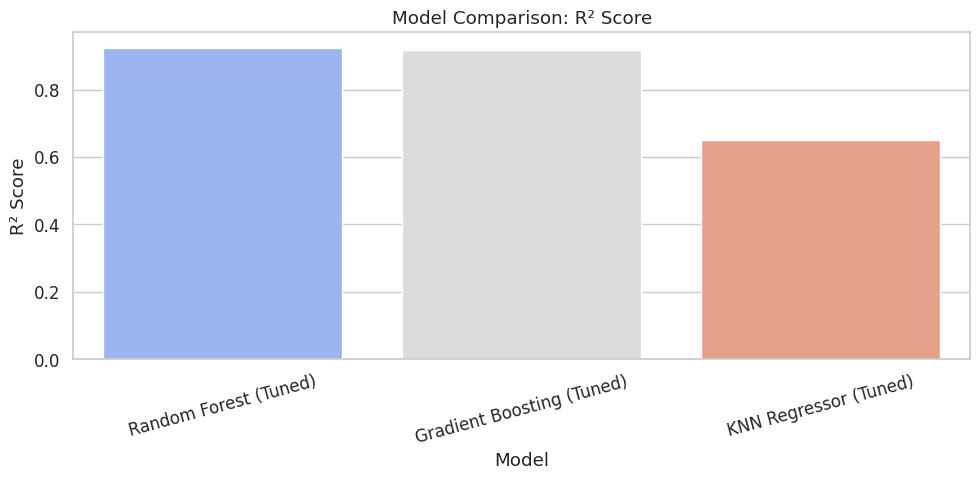

In [16]:
results_df = pd.DataFrame(results).sort_values(by='RMSE')

# Show table
print("\n📋 Model Comparison Table:")
print(results_df)

# RMSE plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='RMSE', palette='crest')
plt.title('Model Comparison: RMSE')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# R² plot
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R² Score', palette='coolwarm')
plt.title('Model Comparison: R² Score')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [17]:

best_rf.fit(X, y)

test_ids = test_data['id'] 


X_test_final, _ = preprocess_data(test_data, target=None)
X_test_final = X_test_final.reindex(columns=X_train.columns, fill_value=0)

preds = best_rf.predict(X_test_final)

submission = pd.DataFrame({
    'id': test_ids,
    'price': preds
})

submission.to_csv('submission.csv', index=False)
print("submission.csv created!")


submission.csv created!
